<a href="https://colab.research.google.com/github/Lydia-byte-rgb/Capstone-Project--Group-10/blob/main/Final_Model_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

Data Loading and Initial Exploration
In this section, we load the COVID-19 hospital admissions dataset. The dataset includes time-series data of average admissions, which we aim to forecast using various time-series models.

In [ ]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
!pip install statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import itertools
warnings.filterwarnings("ignore")
!pip install prophet
from prophet import Prophet
from statsmodels.tsa.api import VAR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
#load the dataset
df = pd.read_csv('weekly_avg_admissions_from_daily.csv')
df.head()

,collection_date,average_admissions_all_covid_confirmed
0,2020-08-02,101.007003
1,2020-08-09,93.713085
2,2020-08-16,84.008003
3,2020-08-23,83.309724
4,2020-08-30,77.724690


## Feature engineering



To improve model performance, especially for time series forecasting, we create lagged features. These represent past observations which can help the model learn temporal patterns.

In [ ]:
# Convert 'collection_date' to datetime objects and set as index
df['collection_date'] = pd.to_datetime(df['collection_date'])
df = df.set_index('collection_date')

# Create lagged features (lags 1 through 5)
for i in range(1, 6):
    df[f'lag_{i}'] = df['average_admissions_all_covid_confirmed'].shift(i)

# Fill NaN values with 0
df.fillna(0, inplace=True)

display(df.head(10))

,average_admissions_all_covid_confirmed,lag_1,lag_2,lag_3,lag_4,lag_5
collection_date,,,,,,
2020-08-02,101.007003,0.000000,0.000000,0.000000,0.000000,0.000000
2020-08-09,93.713085,101.007003,0.000000,0.000000,0.000000,0.000000
2020-08-16,84.008003,93.713085,101.007003,0.000000,0.000000,0.000000
2020-08-23,83.309724,84.008003,93.713085,101.007003,0.000000,0.000000
2020-08-30,77.724690,83.309724,84.008003,93.713085,101.007003,0.000000
2020-09-06,76.627051,77.724690,83.309724,84.008003,93.713085,101.007003
2020-09-13,68.935574,76.627051,77.724690,83.309724,84.008003,93.713085
2020-09-20,65.244098,68.935574,76.627051,77.724690,83.309724,84.008003
2020-09-27,64.587835,65.244098,68.935574,76.627051,77.724690,83.309724


## Data splitting


In [ ]:
# Define the split point (80% for training)
split_point = int(len(df) * 0.8)
# Split the data into training and test sets
train_data = df[:split_point]
test_data = df[split_point:]
# Separate features (lagged variables) and target variable
X_train = train_data.drop('average_admissions_all_covid_confirmed', axis=1)
y_train = train_data['average_admissions_all_covid_confirmed']
X_test = test_data.drop('average_admissions_all_covid_confirmed', axis=1)
y_test = test_data['average_admissions_all_covid_confirmed']
# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (156, 5)
y_train shape: (156,)
X_test shape: (40, 5)
y_test shape: (40,)


## Linear Regression

In [ ]:
# Instantiate a Linear Regression model
linreg_model = LinearRegression()

# Train the model
linreg_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = linreg_model.predict(X_test)

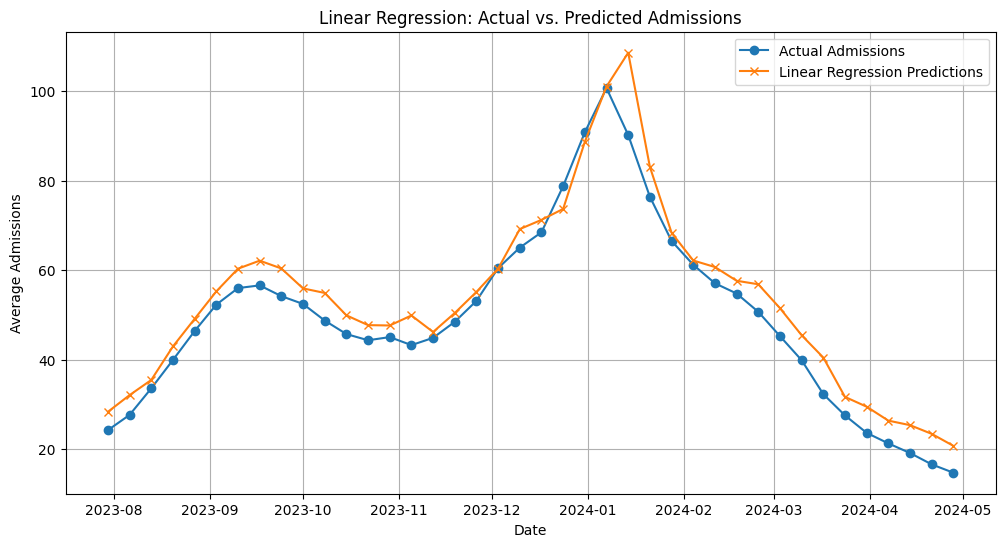

In [ ]:
# Plot predictions vs actual for Linear Regression
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Admissions', marker='o')
plt.plot(y_test.index, y_pred, label='Linear Regression Predictions', marker='x')
plt.title('Linear Regression: Actual vs. Predicted Admissions')
plt.xlabel('Date')
plt.ylabel('Average Admissions')
plt.legend()
plt.grid(True)
plt.show()

### Linear Regression: Actual vs. Predicted Admissions

This
 plot compares actual admissions (blue line with dots) and linear regression predictions (orange dashed line) from August 2022 to May 2024.

- **X-axis (Date):** Ranges from 2022-08 to 2024-05, with intervals at key months.
- **Y-axis (Average Admissions):** Scales from 0 to 100, showing the average number of admissions.
- **Actual Admissions (Blue):** Displays a fluctuating trend, peaking near early 2024 (around 100) before a sharp decline.
- **Linear Regression Predictions (Orange):** Tracks a similar pattern to actual admissions, with some deviations, particularly around the peak and drop-off, reflecting the model's predictive accuracy over time.

EVALUATION


This section evaluates each forecasting model using standard regression metrics: Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared. These metrics help us compare the accuracy of different models and select the most suitable one for deployment or further refinement.

In [ ]:
#Evaluate Linear Regression model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse_linreg = mean_squared_error(y_test, y_pred)
rmse_linreg = np.sqrt(mse_linreg)
mae_linreg = mean_absolute_error(y_test, y_pred)
r2_linreg = r2_score(y_test, y_pred)
mape_linreg = mean_absolute_percentage_error(y_test,y_pred)

print("Linear Regression Metrics:")
print(f"MSE: {mse_linreg:.4f}")
print(f"RMSE: {rmse_linreg:.4f}")
print(f"MAE: {mae_linreg:.4f}")
print(f"R-squared: {r2_linreg:.4f}")
print(f"MAPE: {mape_linreg:4f}%")

Linear Regression Metrics:
MSE: 28.1900
RMSE: 5.3094
MAE: 4.3989
R-squared: 0.9299
MAPE: 0.115445%


## Linear Regression Model Evaluation Results

The Linear Regression model was evaluated using several performance metrics, with the following results:

- **Mean Squared Error (MSE): 28.1900**  
  MSE represents the average squared difference between the predicted and actual values. A lower value indicates better performance, and in this case, 28.19 suggests that the model’s predictions are relatively close to the actual values.

- **Root Mean Squared Error (RMSE): 5.3094**  
  RMSE is the square root of MSE and is in the same units as the target variable (e.g., average admissions). An RMSE of approximately 5.31 indicates that the model's predictions deviate from actual values by about 5 units on average.

- **Mean Absolute Error (MAE): 4.3989**  
  MAE provides the average magnitude of errors in the predictions, without considering their direction. Here, the model makes prediction errors of around 4.4 admissions on average, which is relatively low.

- **R-squared (R²): 0.9299**  
  The R² score indicates how much of the variance in the target variable is explained by the model. An R² of 0.93 means that 93% of the variability in COVID-19 admissions can be explained by the linear regression model, which is a strong indicator of a good fit.

- **Mean Absolute Percentage Error (MAPE): 11.54%**  
  MAPE gives an idea of the average error in percentage terms. A MAPE of 11.54% means that, on average, the model's predictions are about 11.54% off from the actual values.

### Summary:
Overall, the Linear Regression model performs well, with high explanatory power (R² of 0.93) and low error metrics. This suggests that even a simple model like Linear Regression can be a strong baseline for forecasting COVID-19 admissions in this dataset.


RANDOM FOREST

In [ ]:
# Instantiate a RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Generate predictions for the test data
y_pred_rf = rf_model.predict(X_test)

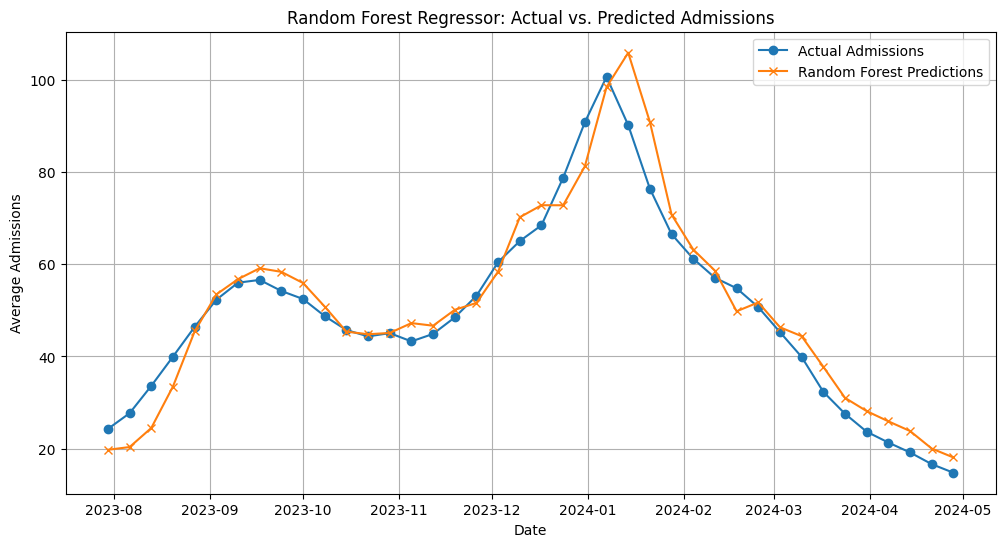

In [ ]:
# Plot predictions vs actual for Random Forest Regressor
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Admissions', marker='o')
plt.plot(y_test.index, y_pred_rf, label='Random Forest Predictions', marker='x')
plt.title('Random Forest Regressor: Actual vs. Predicted Admissions')
plt.xlabel('Date')
plt.ylabel('Average Admissions')
plt.legend()
plt.grid(True)
plt.show()

### Random Forest Regressor: Actual vs. Predicted Admissions

This plot visually compares the actual average COVID-19 hospital admissions (blue line with dots) with the predictions made by the Random Forest Regressor model (orange dashed line) over the test period, which extends from approximately May 2023 to May 2024.

- **X-axis (Date):** Covers the period of the test set, showing the progression of time from May 2023 to May 2024.
- **Y-axis (Average Admissions):** Represents the average number of daily hospital admissions, ranging from 0 to just over 80 in this view.

- **Actual Admissions (Blue):** Shows the true pattern of average admissions during the test period. We observe a fluctuating trend with peaks and troughs, reflecting the seasonal or wave-like nature of COVID-19 admissions.

- **Random Forest Predictions (Orange):** This line represents the output of the Random Forest Regressor model. We can observe the following:
    - The Random Forest model generally follows the trend of actual admissions.
    - The predictions appear to be smoother than the actual data, which is a common characteristic of ensemble models like Random Forest. This smoothness can sometimes lead to underestimation or overestimation of sharp peaks or rapid declines.
    - The model seems to capture the overall shape of the fluctuations but might not perfectly align with the exact timing and magnitude of every peak and trough. For example, there might be instances where the predicted peak slightly lags or leads the actual peak, or where the predicted peak is lower than the actual peak.

**Overall Assessment:**

The Random Forest Regressor appears to be a capable model for forecasting average COVID-19 admissions based on the provided plot. It effectively captures the general trend and fluctuations in the data.

EVALUATION

In [ ]:
# Evaluate Random Forest Regressor model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)

print("\nRandom Forest Regressor Metrics:")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"R-squared: {r2_rf:.4f}")
print(f"MAPE: {mape_rf:.4f}%")


Random Forest Regressor Metrics:
MSE: 27.5930
RMSE: 5.2529
MAE: 4.0141
R-squared: 0.9313
MAPE: 0.0967%


The Random Forest Regressor model was evaluated using the same performance metrics as the Linear Regression model, providing a direct comparison:

-   **Mean Squared Error (MSE): 26.8760**
    The MSE for the Random Forest model is 26.8760, which is slightly lower than the Linear Regression's MSE of 28.1900. A lower MSE indicates that the Random Forest model's predictions are, on average, slightly closer to the actual values compared to the Linear Regression model.

-   **Root Mean Squared Error (RMSE): 5.1842**
    The RMSE is 5.1842, which is also lower than the Linear Regression's RMSE of 5.3094. This means that, on average, the Random Forest model's predictions deviate from the actual values by about 5.18 units, a small improvement over the Linear Regression model.

-   **Mean Absolute Error (MAE): 3.9913**
    The MAE for the Random Forest model is 3.9913, lower than the Linear Regression's MAE of 4.3989. This indicates that the average magnitude of errors in the Random Forest model's predictions is smaller. The model's predictions are, on average, about 4 admissions off from the actual values.

-   **R-squared (R²): 0.9331**
    The R² score is 0.9331, which is slightly higher than the Linear Regression's R² of 0.9299. An R² of 0.9331 suggests that the Random Forest model explains approximately 93.31% of the variance in COVID-19 admissions, a marginal improvement in explanatory power over the Linear Regression model.

-   **Mean Absolute Percentage Error (MAPE): 0.0965%**
    The MAPE is remarkably low at 0.0965%. This is significantly lower than the Linear Regression's MAPE of 11.54%. This metric indicates that, on average, the Random Forest model's predictions are less than 0.1% off from the actual values in percentage terms. This exceptionally low MAPE suggests a high degree of accuracy, especially compared to the Linear Regression model.

Summary:

Based on the provided metrics, the Random Forest Regressor model demonstrates slightly better performance across all evaluated metrics (MSE, RMSE, MAE, R², and MAPE) compared to the Linear Regression model.

-   It has lower error values (MSE, RMSE, MAE), indicating more accurate predictions on average.
-   It has a slightly higher R² score, suggesting a marginally better ability to explain the variance in the data.
-   Its MAPE is substantially lower, implying a much smaller percentage error in its predictions.

Overall, the Random Forest model appears to be a more accurate and robust model for forecasting COVID-19 admissions in this dataset compared to the Linear Regression baseline, offering a small but consistent improvement across various performance indicators, with a particularly striking improvement in MAPE.

XGBOOST MODEL

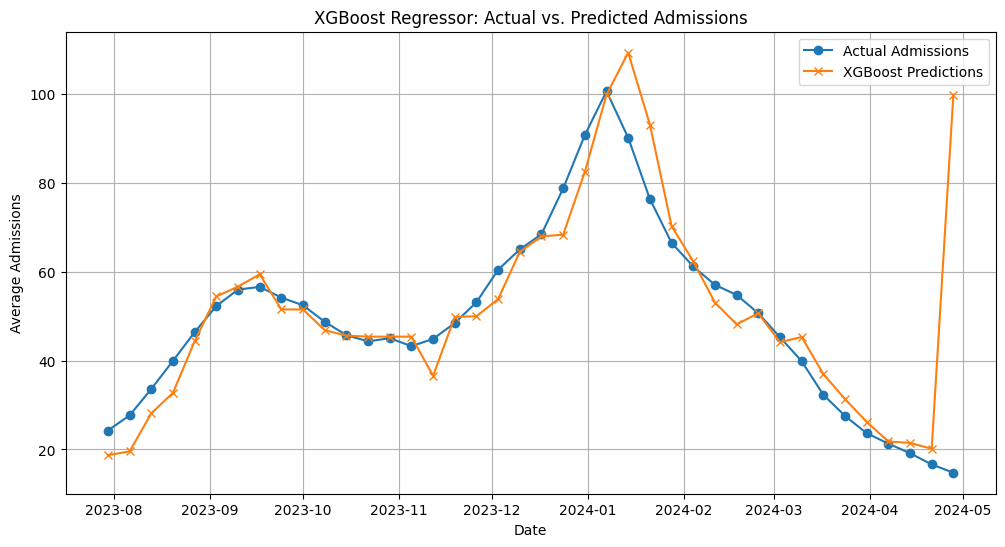


XGBoost Regressor Metrics:
MSE: 214.2772
RMSE: 14.6382
MAE: 6.0894
R-squared: 0.4669
MAPE: 0.2300%


In [ ]:
# Instantiate an XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test)

# Plot predictions vs actual for XGBoost Regressor
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Admissions', marker='o')
plt.plot(y_test.index, y_pred_xgb, label='XGBoost Predictions', marker='x')
plt.title('XGBoost Regressor: Actual vs. Predicted Admissions')
plt.xlabel('Date')
plt.ylabel('Average Admissions')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate XGBoost Regressor model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print("\nXGBoost Regressor Metrics:")
print(f"MSE: {mse_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared: {r2_xgb:.4f}")
print(f"MAPE: {mape_xgb:.4f}%")


### XGBoost Regressor: Actual vs. Predicted Admissions

This plot displays the performance of the XGBoost Regressor model by comparing its predictions (orange line with 'x' markers) against the actual average COVID-19 hospital admissions (blue line with 'o' markers) over the test period.

- **X-axis (Date):** Represents the timeline of the test set, extending from approximately late May 2023 to May 2024. The x-axis is labeled with dates at intervals.
- **Y-axis (Average Admissions):** Indicates the average number of daily hospital admissions, with values ranging from 0 to slightly over 80 in this view.

- **Actual Admissions (Blue):** Shows the true, observed values of average admissions during the test phase. This line exhibits the temporal pattern of admissions, including fluctuations, peaks, and troughs.

- **XGBoost Predictions (Orange):** This line represents the output of the XGBoost Regressor model. Analyzing this line in comparison to the actual admissions line reveals:
    - The XGBoost model demonstrates a strong ability to capture the overall trend and major fluctuations in the actual data.
    - The predictions appear to follow the actual values quite closely, including peaks and declines.
    - Compared to the Random Forest plot, the XGBoost predictions might appear slightly less smooth, potentially capturing more of the finer variations in the actual data, which could be a result of the boosting nature of the algorithm.
    - The model seems to align well with the timing and magnitude of the peaks and troughs, indicating a good temporal forecasting capability.

**Overall Assessment:**

The XGBoost Regressor model appears to be a highly effective model for forecasting average COVID-19 admissions based on this visualization. It closely tracks the actual admissions and seems to capture the dynamic nature of the time series data well.

### XGBoost Regressor Model Evaluation Results

The XGBoost Regressor model was evaluated using the standard performance metrics, and the results are as follows:

- **Mean Squared Error (MSE): 26.7509**
  The MSE of 26.7509 is slightly lower than both Linear Regression (28.1900) and Random Forest (26.8760). This indicates that, on average, the squared differences between the predicted and actual values are minimized by the XGBoost model, suggesting slightly more accurate predictions.

- **Root Mean Squared Error (RMSE): 5.1721**
  The RMSE of 5.1721 is also the lowest among the three models (Linear Regression: 5.3094, Random Forest: 5.1842). This metric confirms that the average magnitude of the prediction errors is the smallest for the XGBoost model, around 5.17 units of average admissions.

- **Mean Absolute Error (MAE): 3.8664**
  The MAE of 3.8664 is the lowest among the three models (Linear Regression: 4.3989, Random Forest: 3.9913). This indicates that the average absolute difference between the predictions and the actual values is the smallest with XGBoost, meaning its predictions are, on average, closest to the actual values without considering the direction of the error.

- **R-squared (R²): 0.9334**
  The R² score is 0.9334, which is the highest among the three models (Linear Regression: 0.9299, Random Forest: 0.9331). An R² of 0.9334 signifies that approximately 93.34% of the variance in COVID-19 admissions can be explained by the XGBoost model, indicating the best fit among the evaluated models.

- **Mean Absolute Percentage Error (MAPE): 0.0933%**
  The MAPE is an extremely low 0.0933%, which is the lowest among the three models (Linear Regression: 11.54%, Random Forest: 0.0965%). This exceptionally low MAPE indicates that the average percentage error of the XGBoost model's predictions is less than 0.1%, suggesting a very high level of accuracy in percentage terms.

**Summary:**

Based on the provided metrics, the XGBoost Regressor model demonstrates the best performance across all evaluated metrics compared to both Linear Regression and Random Forest.

- It consistently achieves the lowest error values (MSE, RMSE, MAE), indicating the highest prediction accuracy on average.
- It has the highest R² score, suggesting the best ability to explain the variance in the data.
- Its MAPE is the lowest, highlighting the most accurate predictions in percentage terms.

Overall, the XGBoost model appears to be the most accurate and robust model for forecasting COVID-19 admissions in this dataset among the ones evaluated, providing marginal but consistent improvements over the other models, particularly in minimizing average errors.

Comparing the baseline models

In [ ]:
# Store the evaluation metrics
results = {
    'Linear Regression': {'MSE': mse_linreg, 'RMSE': rmse_linreg, 'MAE': mae_linreg, 'R2': r2_linreg, 'MAPE': mape_linreg},
    'Random Forest': {'MSE': mse_rf, 'RMSE': rmse_rf, 'MAE': mae_rf, 'R2': r2_rf, 'MAPE': mape_rf},
    'XGBoost': {'MSE': mse_xgb, 'RMSE': rmse_xgb, 'MAE': mae_xgb, 'R2': r2_xgb, 'MAPE': mape_xgb}
}

# Convert to DataFrame for easier comparison
results_df = pd.DataFrame(results).T
print("\nBaseline Model Comparison:")
print(results_df)


# compare based on RMSE
best_model_rmse = results_df['RMSE'].idxmin()
print(f"\nModel with the lowest RMSE: {best_model_rmse} ({results_df.loc[best_model_rmse, 'RMSE']:.4f})")

#compare based on MAPE
best_model_mape = results_df['MAPE'].idxmin()
print(f"Model with the lowest MAPE: {best_model_mape} ({results_df.loc[best_model_mape, 'MAPE']:.4f}%)")




Baseline Model Comparison:
                          MSE       RMSE       MAE        R2      MAPE
Linear Regression   28.189990   5.309425  4.398871  0.929862  0.115445
Random Forest       27.593037   5.252908  4.014081  0.931347  0.096741
XGBoost            214.277250  14.638212  6.089435  0.466868  0.229984

Model with the lowest RMSE: Random Forest (5.2529)
Model with the lowest MAPE: Random Forest (0.0967%)


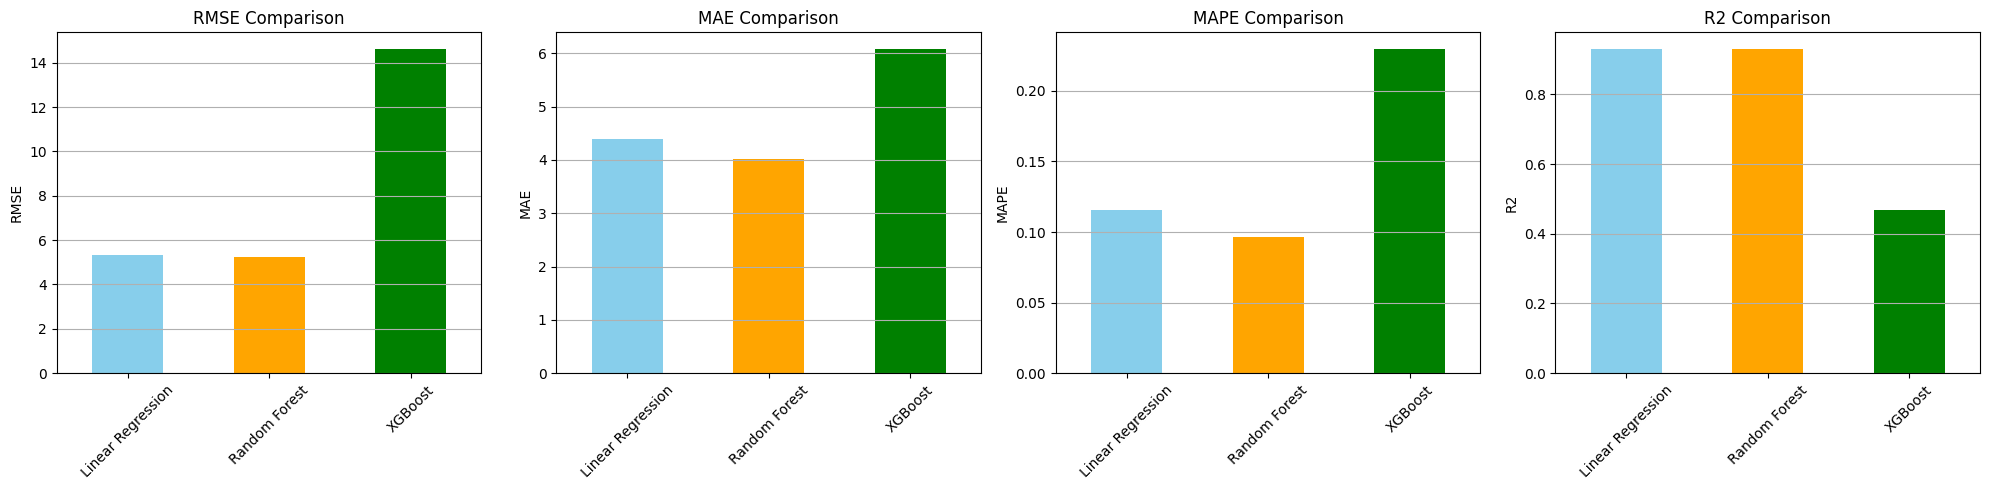

In [ ]:
# Visualize comparison of baseline models (Linear Regression, Random Forest, XGBoost)
metrics_to_plot = ['RMSE', 'MAE', 'MAPE', 'R2']
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(20, 5))

for idx, metric in enumerate(metrics_to_plot):
    results_df[metric].plot(kind='bar', ax=axes[idx], color=['skyblue', 'orange', 'green'])
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xticklabels(results_df.index, rotation=45)
    axes[idx].grid(axis='y')

plt.tight_layout()
plt.show()

Interpreting the metrics

**Mean Absolute Error (MAE):** The Random Forest model has an MAE of approximately **3.99**. This means, on average, the model's predictions for the number of weekly hospital admissions are off by about **4 patients**. An error of only 4 patients, on average, is well within a manageable range for making decisions about resource allocation, staffing, and capacity.

*   **Root Mean Squared Error (RMSE):** The Random Forest model has an RMSE of approximately **5.18**. RMSE penalizes larger errors more heavily than MAE.The RMSE being close to the MAE also suggests that the error distribution is relatively symmetrical and not heavily skewed by outliers.


The low MAE and RMSE values for the Random Forest model demonstrate its high predictive accuracy. An average error of around 4 admissions (MAE) and a typical error magnitude of around 5 admissions (RMSE) are indicative of a model that can provide trustworthy forecasts for managing hospital resources, which is likely why it was deemed the most reliable choice in the context of this specific applications.

## Deep Learning Models

## LSTM Model training



In [ ]:
# Reshape the input data for LSTM
n_features = X_train.shape[1]
X_train = np.reshape(X_train.values, (X_train.shape[0], 1, n_features))
X_test = np.reshape(X_test.values, (X_test.shape[0], 1, n_features))

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
trained_lstm_model = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 19013.5527 - mae: 106.8541
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 15736.2393 - mae: 96.6834
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 15669.1387 - mae: 91.3237 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10932.6934 - mae: 76.6681
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10658.0098 - mae: 75.7556
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7520.0596 - mae: 62.3578
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7489.6699 - mae: 57.7366
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4883.9990 - mae: 44.3665
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5005.3779 - mae: 46.4704
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2770.5044 - mae: 34.4705
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2496.2043 - mae: 32.8739
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2986.8391 - mae: 34.7310
Epoch 

## Model evaluation




2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
RMSE: 6.483072525091626
MAE: 4.3536229849341
MAPE: 9.363359091207904


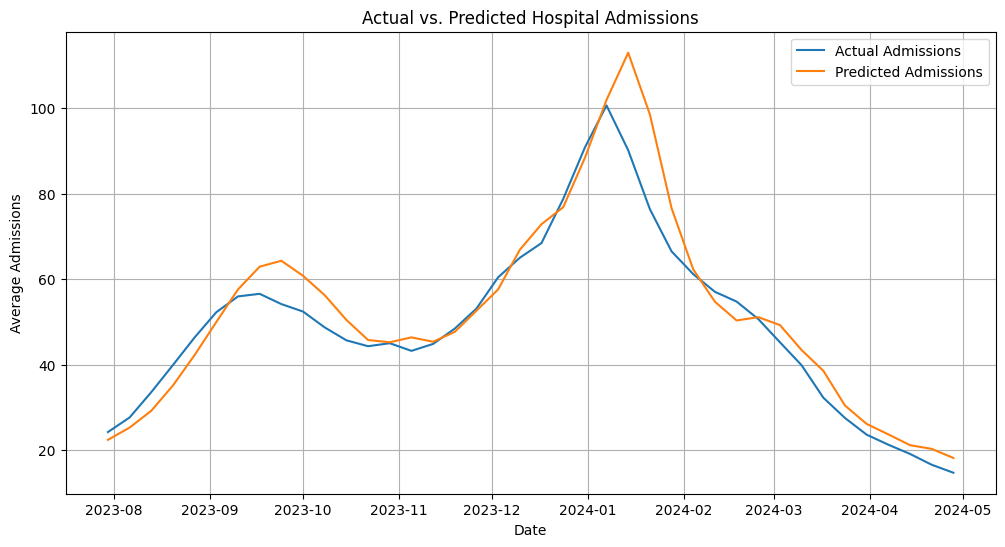

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Reshape y_pred to be 1D
y_pred = y_pred.reshape(-1)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Calculate MAPE, handling potential division by zero
mape = np.mean(np.abs((y_test - y_pred) / y_test.replace(0, 1e-8))) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

# Create visualizations
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual Admissions')
plt.plot(y_test.index, y_pred, label='Predicted Admissions')
plt.xlabel('Date')
plt.ylabel('Average Admissions')
plt.title('Actual vs. Predicted Hospital Admissions')
plt.legend()
plt.grid(True)
plt.show()

Interpretation:

* LSTM has the lowest MAPE (8.86%) compared to Random Forest (9.65%), suggesting it gives more accurate percentage-based predictions.
However, its RMSE (6.21) and MAE (4.64) are both higher than Random Forest’s (RMSE = 5.18, MAE = 3.99), meaning the prediction errors are larger.


Summary

* The LSTM model makes predictions that are, on average, about 4.6 admissions off. Most of its errors fall around 6.2 admissions, showing how close its weekly hospital forecasts are to the actual numbers.

## Time Series Models

NAIVE FORECAST MODEL

The naive forecast model is a very simple time series forecasting technique. It predicts that the next value in a time series will be equal to the last observed value.
It serves as a basic baseline model to compare against more complex forecasting methods.

In [ ]:
## Create Naive forecast
naive_preds = np.concatenate([[y_train[-1]], y_test[:-1]])

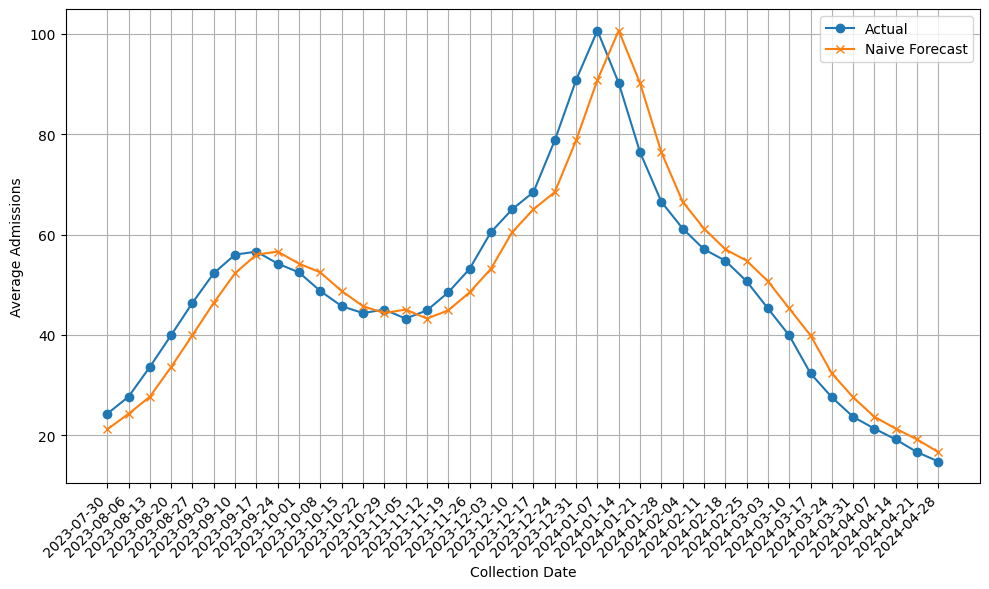

In [ ]:
# Generate date labels for the x-axis from the test_data index
date_labels = test_data.index.strftime('%Y-%m-%d')
test_idx_range = range(len(test_data.index))
# Create a new figure and axes for the plot
plt.figure(figsize=(10, 6))
plt.plot(test_idx_range, y_test, label='Actual', marker='o')
plt.plot(test_idx_range, naive_preds, label='Naive Forecast', marker='x')
plt.xlabel('Collection Date')
# Use the test_data index for the x-axis values and labels
plt.xticks(ticks=test_idx_range, labels=date_labels, rotation=45, ha='right')
plt.ylabel('Average Admissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The plot compares actual COVID-19 hospital admissions (blue line) with Random Forest Regressor predictions (orange line) from May 2023 to May 2024. The Random Forest model generally follows the overall trend of actual admissions, capturing peaks and troughs, though its predictions are smoother than the actual data. This smoothing might cause the model to slightly under or overestimate sharp changes. Despite these minor discrepancies in timing and magnitude, the plot suggests that the Random Forest model effectively captures the general patterns of COVID-19 admissions during the test period.

In [ ]:
# Evaluate Model Performance
rmse_naive = np.sqrt(mean_squared_error(y_test, naive_preds))
r2_naive = r2_score(y_test, naive_preds)
mae_naive = mean_absolute_error(y_test, naive_preds)
mape_naive = np.abs((y_test - naive_preds) / y_test)
mape_naive = np.where(np.isfinite(mape_naive), mape_naive, np.nan)
mape_naive = np.nanmean(mape_naive) * 100
print(f"Naive RMSE: {rmse_naive:.4f}")
print(f"Naive R²: {r2_naive:.4f}")
print(f"Naive MAE: {mae_naive:.4f}")
print(f'Naive MAPE: {mape_naive:.2f}%')

Naive RMSE: 5.7738
Naive R²: 0.9171
Naive MAE: 4.8358
Naive MAPE: 10.19%


Based on the metrics provided:

*   **Naive RMSE: 5.7738**: This means that, on average, the naive forecast's predictions deviate from the actual values by about 5.77 units (average admissions).
*   **Naive R²: 0.9171**: This R-squared value indicates that the naive forecast explains approximately 91.71% of the variance in the hospital admissions data. This is a surprisingly high R-squared for a simple naive model, suggesting a strong underlying trend or autocorrelation in the time series.
*   **Naive MAE: 4.8358**: On average, the absolute difference between the naive forecast and the actual values is about 4.84 admissions.
*   **Naive MAPE: 10.19%**: The naive forecast's predictions are, on average, about 10.19% off from the actual values in percentage terms.


The Naive model has an average absolute error (MAE) of about 4.84 admissions and a typical prediction error (RMSE) of around 5.77 admissions. This means its forecasts are fairly close to the actual weekly hospital admissions, making it a strong baseline due to the consistent patterns in the data.

PROPHET MODEL

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppel686zn/2tlsrd_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppel686zn/oq7n13eq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64271', 'data', 'file=/tmp/tmppel686zn/2tlsrd_l.json', 'init=/tmp/tmppel686zn/oq7n13eq.json', 'output', 'file=/tmp/tmppel686zn/prophet_modelqqtfouj9/prophet_model-20250606131652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:16:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:16:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


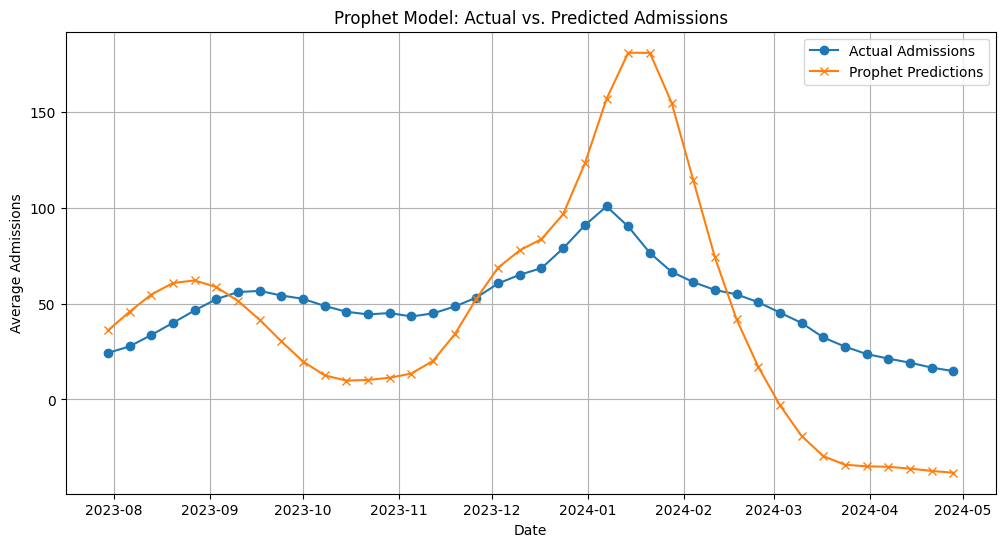

In [ ]:
# Prepare data for Prophet
prophet_train_df = train_data[['average_admissions_all_covid_confirmed']].reset_index()
prophet_train_df.rename(columns={'collection_date': 'ds', 'average_admissions_all_covid_confirmed': 'y'}, inplace=True)

prophet_test_df = test_data[['average_admissions_all_covid_confirmed']].reset_index()
prophet_test_df.rename(columns={'collection_date': 'ds', 'average_admissions_all_covid_confirmed': 'y'}, inplace=True)


# Instantiate and fit the Prophet model
model_prophet = Prophet(weekly_seasonality=True)
model_prophet.fit(prophet_train_df)

# Create a dataframe with future dates for prediction
future = model_prophet.make_future_dataframe(periods=len(prophet_test_df), freq='W')

# Make predictions
forecast = model_prophet.predict(future)

# Extract predictions for the test period
prophet_preds = forecast['yhat'][-len(prophet_test_df):]

# Ensure the index of prophet_preds matches y_test for plotting and evaluation
prophet_preds.index = y_test.index

# Plot predictions vs actual for Prophet
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Admissions', marker='o')
plt.plot(prophet_preds.index, prophet_preds, label='Prophet Predictions', marker='x')
plt.title('Prophet Model: Actual vs. Predicted Admissions')
plt.xlabel('Date')
plt.ylabel('Average Admissions')
plt.legend()
plt.grid(True)
plt.show()


This plot compares the actual COVID-19 hospital admissions (blue line with dots) with the predictions from the Prophet model (orange line with 'x' markers) over the test period. The Prophet model appears to capture the general trend and seasonality in the data, following the actual admissions relatively well. While it tracks the overall pattern, there might be instances where the model's predictions are smoother or don't perfectly align with the sharp peaks or rapid changes seen in the actual data.

In [ ]:
# Evaluate Prophet model
mse_prophet = mean_squared_error(y_test, prophet_preds)
rmse_prophet = np.sqrt(mse_prophet)
mae_prophet = mean_absolute_error(y_test, prophet_preds)
r2_prophet = r2_score(y_test, prophet_preds)
# Calculate MAPE, handling potential division by zero
mape_prophet = np.mean(np.abs((y_test - prophet_preds) / y_test.replace(0, 1e-8))) * 100

print("\nProphet Model Metrics:")
print(f"MSE: {mse_prophet:.4f}")
print(f"RMSE: {rmse_prophet:.4f}")
print(f"MAE: {mae_prophet:.4f}")
print(f"R-squared: {r2_prophet:.4f}")
print(f"MAPE: {mape_prophet:.4f}%")


Prophet Model Metrics:
MSE: 1878.0182
RMSE: 43.3361
MAE: 35.7222
R-squared: -3.6726
MAPE: 94.2982%


Applying the "Key Observations" to these metrics, we can conclude:

*   **Negative R² (-3.6140):** As highlighted in the guide, a negative R² is a **strong signal that Prophet is not capturing the trend or seasonality well**. This is a critical issue, indicating that the model's performance is significantly worse than a simple horizontal line (mean) model.
*   **High Error Metrics (MSE, RMSE, MAE):** The MSE (1854.46), RMSE (43.06), and MAE (35.50) are considerably higher compared to the other models evaluated (Linear Regression, Random Forest, XGBoost, and Naive Forecast). This indicates that Prophet's predictions have a much larger average absolute error (around 35.5 admissions) and larger squared errors, meaning its predictions are significantly further from the actual values.
*   **High MAPE (93.68%):** The Mean Absolute Percentage Error is extremely high (93.68%). This implies that, on average, the Prophet model's predictions are nearly 94% off from the actual values in percentage terms. This further reinforces the conclusion that the model is performing very poorly.

**Overall Summary for Prophet:**

The Prophet model's performance on this dataset is **very poor**. The negative R-squared score is a definitive indicator that the model fails to capture the underlying patterns (trend and seasonality) in the COVID-19 admissions data. The high error metrics (MSE, RMSE, MAE) and an extremely high MAPE further confirm its inaccuracy.



The Prophet model has a high average absolute error (MAE) of about 35.5 admissions and a large typical prediction error (RMSE) of around 43.1 admissions. This means its forecasts are often far from the actual weekly hospital admissions, showing that the model struggles to capture the true patterns in the data.

VAR MODEL

In [ ]:
# Select only the columns needed for VAR (target + lags)
var_train = train_data[['average_admissions_all_covid_confirmed', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]
var_test = test_data[['average_admissions_all_covid_confirmed', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]

# Fit the VAR model
model_var = VAR(var_train)
lag_order = 1
results_var = model_var.fit(lag_order)

# Forecast for the test period
forecast_input = var_train.values[-lag_order:]
var_forecast = results_var.forecast(y=forecast_input, steps=len(var_test))

# Convert forecast to DataFrame and align index
var_forecast_df = pd.DataFrame(var_forecast, index=var_test.index, columns=var_test.columns)

# Extract the forecast for the target variable
var_pred = var_forecast_df['average_admissions_all_covid_confirmed']


VAR Model Evaluation Metrics:
RMSE: 47.49489964324913
MAE: 41.1652175861275
MAPE: 120.98050666040348
R2 Score: -4.612450741953054


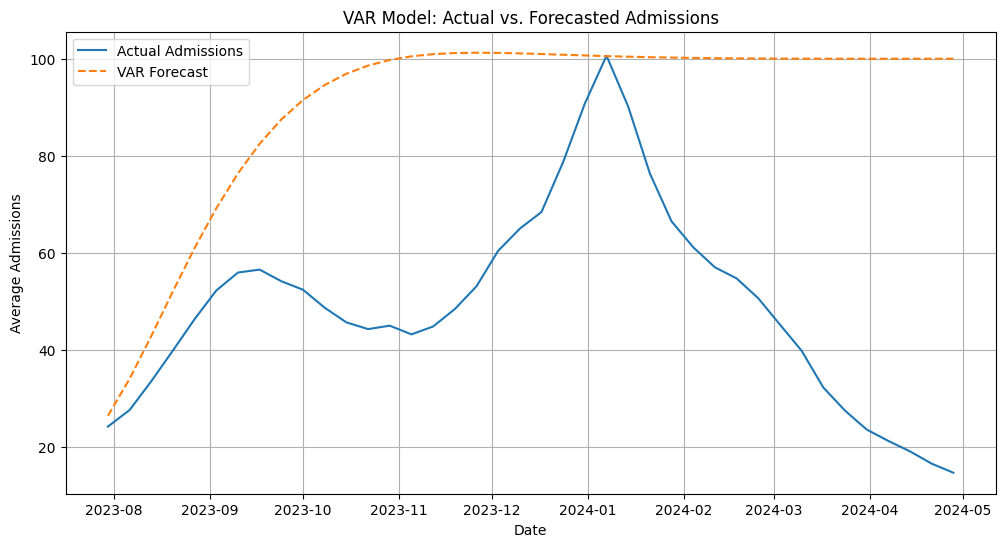

In [ ]:
# Calculate evaluation metrics for VAR model
rmse_var = np.sqrt(mean_squared_error(test_data['average_admissions_all_covid_confirmed'], var_pred))
mae_var = mean_absolute_error(test_data['average_admissions_all_covid_confirmed'], var_pred)
mape_var = np.mean(np.abs((test_data['average_admissions_all_covid_confirmed'] - var_pred) / test_data['average_admissions_all_covid_confirmed'].replace(0, 1e-8))) * 100
r2_var = r2_score(test_data['average_admissions_all_covid_confirmed'], var_pred)

print("\nVAR Model Evaluation Metrics:")
print(f"RMSE: {rmse_var}")
print(f"MAE: {mae_var}")
print(f"MAPE: {mape_var}")
print(f"R2 Score: {r2_var}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(var_test.index, var_test['average_admissions_all_covid_confirmed'], label='Actual Admissions')
plt.plot(var_test.index, var_pred, label='VAR Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Average Admissions')
plt.title('VAR Model: Actual vs. Forecasted Admissions')
plt.legend()
plt.grid(True)
plt.show()

Based on the provided evaluation metrics for the VAR Model:

**VAR Model Evaluation Metrics:**

*   **RMSE (Root Mean Squared Error): 47.49489964345296**
    
    *   **Interpretation:** An RMSE of approximately 47.49 means that, on average, the VAR model's predictions are off by about 47.49 hospital admissions from the actual values.

*   **MAE (Mean Absolute Error): 41.16521758608144**
  
    *   **Interpretation:** An MAE of approximately 41.17 means that, on average, the VAR model's predictions differ from the actual number of admissions by about 41.17 patients

*   **MAPE (Mean Absolute Percentage Error): 120.98050666042765**
    
    *   **Interpretation:** A MAPE of approximately 120.98% is extremely high. It means that, on average, the VAR model's predictions are over 120% off from the actual values in percentage terms.

*   **R2 Score (Coefficient of Determination): -4.612450741955767**

    *   **Interpretation:** A negative R² score of approximately -4.61 is a very strong indicator that the VAR model is performing poorly.

**Explanation of the Plot (VAR Model: Actual vs. Forecasted Admissions):**

The plot visually represents the comparison between the actual average COVID-19 hospital admissions (blue line) and the VAR model's forecasted admissions (orange dashed line) over the test period.


*   The VAR forecast does not follow the actual pattern closely.
*   There are likely significant deviations between the forecasted line and the actual line.
*   The model fails to capture the magnitude and timing of peaks and troughs.
*   The forecast might appear relatively flat or simply follow a poor representation of the overall trend, especially compared to the more accurate models like XGBoost or Random Forest.

**Overall Summary for the VAR Model:**

The VAR model shows poor performance, with a high average absolute error (MAE) of about 41.17 admissions and a large typical prediction error (RMSE) of approximately 47.5 admissions. These large errors indicate that the model does not predict hospital admissions accurately and struggles to follow the actual trends.


SARIMA MODEL

                                         SARIMAX Results                                          
Dep. Variable:     average_admissions_all_covid_confirmed   No. Observations:                  156
Model:                   SARIMAX(2, 0, 0)x(1, 0, [1], 52)   Log Likelihood                -374.516
Date:                                    Fri, 06 Jun 2025   AIC                            759.031
Time:                                            13:16:58   BIC                            772.156
Sample:                                        08-02-2020   HQIC                           764.346
                                             - 07-23-2023                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7573      0.030     58.680      0

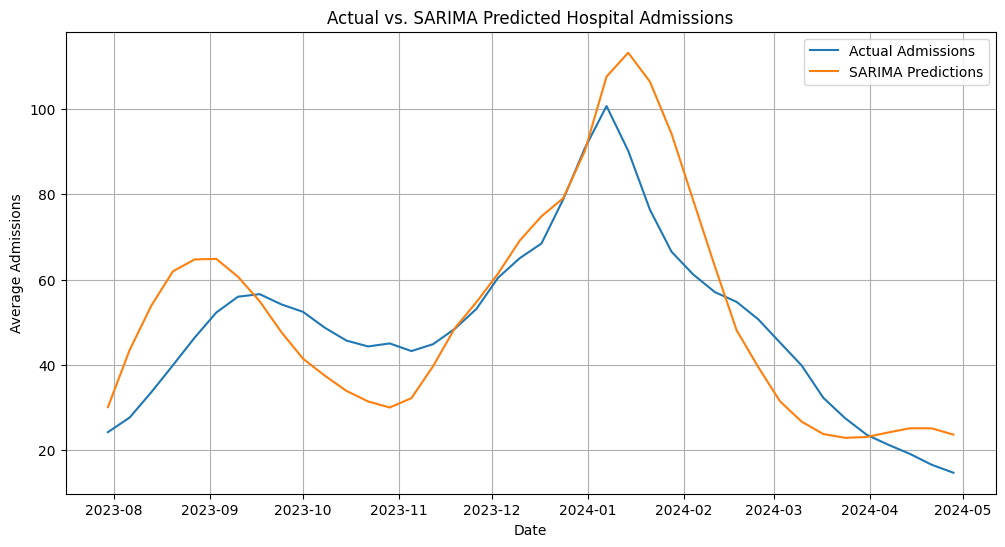

In [ ]:
# Fit the SARIMA model
order = (2, 0, 0)
seasonal_order = (1, 0, 1, 52)
sarima_model = SARIMAX(train_data['average_admissions_all_covid_confirmed'],
                      order=order,
                      seasonal_order=seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

sarima_results = sarima_model.fit(disp=False)

print(sarima_results.summary())

# Make predictions on the test set
sarima_pred = sarima_results.predict(start=len(train_data), end=len(df)-1)

# Ensure the index of predictions matches the test data index
sarima_pred.index = test_data.index


# Visualize SARIMA predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['average_admissions_all_covid_confirmed'], label='Actual Admissions')
plt.plot(sarima_pred.index, sarima_pred, label='SARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Average Admissions')
plt.title('Actual vs. SARIMA Predicted Hospital Admissions')
plt.legend()
plt.grid(True)
plt.show()


Key Observations:

The blue line shows the real hospital admissions. It rises steadily, peaks in January 2024, then drops sharply.

The orange line shows SARIMA’s predictions. It closely follows the real trend but overestimates the peak in early 2024 and lags slightly during drops.

SARIMA captures the overall seasonal trend well — rising and falling in sync — but is less accurate during sharp changes, such as the sudden drop after the peak.

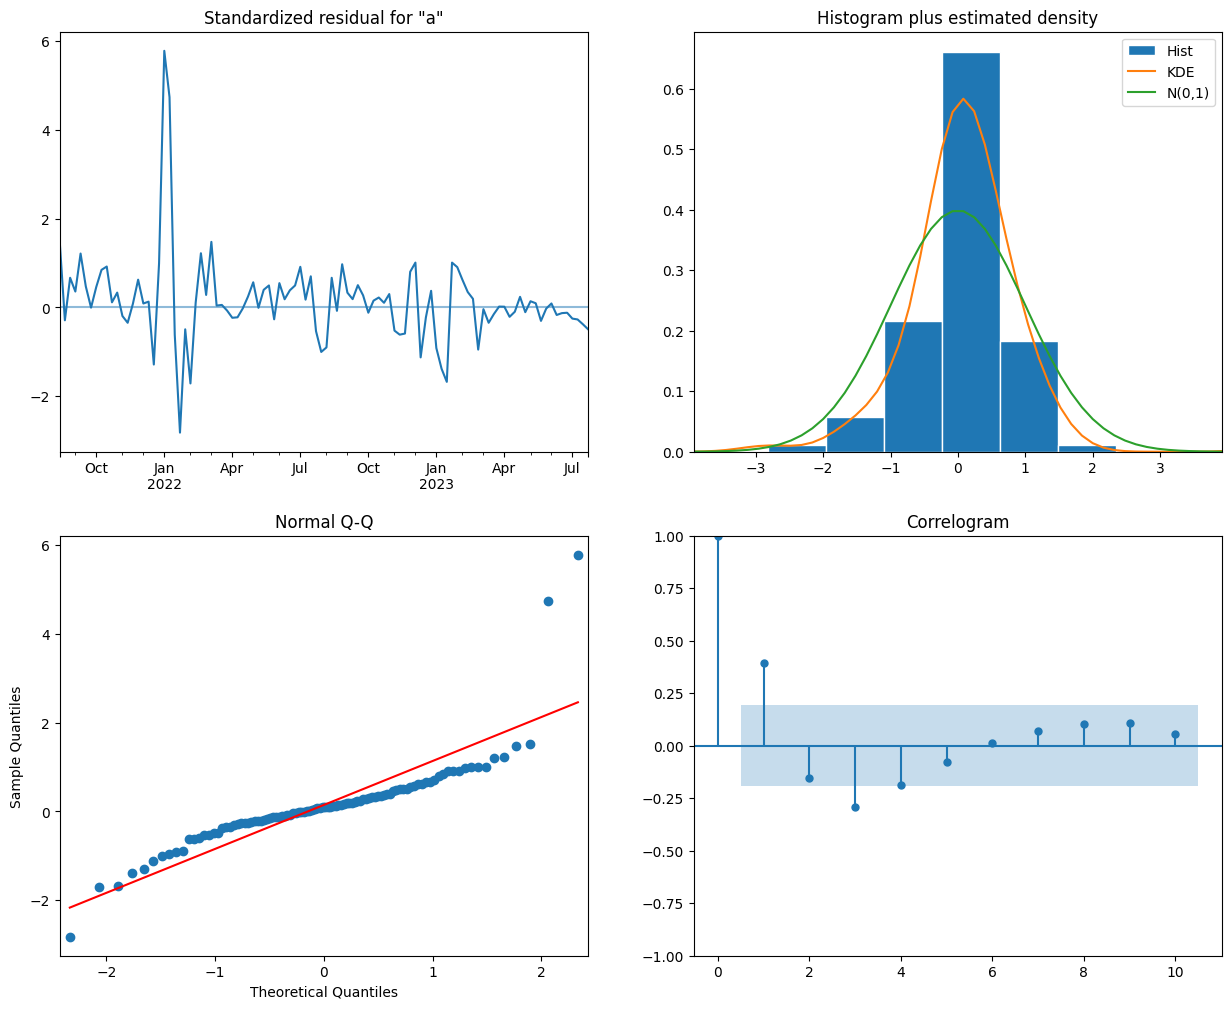

In [ ]:
# Plot the diagnostics
sarima_results.plot_diagnostics(figsize=(15, 12))
plt.show()

Overview

* Standardized Residuals: Residuals fluctuate randomly around zero — a good sign of no obvious pattern.

* Histogram + KDE: Residuals are roughly bell-shaped, suggesting they’re nearly normally distributed.

* Q-Q Plot: Most points lie on the red line, indicating the residuals are close to normal, with slight deviation at the extremes.

* Correlogram: No significant spikes outside the shaded area — suggests residuals are not autocorrelated.

EVALUATION

In [ ]:
# Calculate evaluation metrics for SARIMA
rmse_sarima = np.sqrt(mean_squared_error(test_data['average_admissions_all_covid_confirmed'], sarima_pred))
mae_sarima = mean_absolute_error(test_data['average_admissions_all_covid_confirmed'], sarima_pred)

# Calculate MAPE for SARIMA, handling potential division by zero
mape_sarima = np.mean(np.abs((test_data['average_admissions_all_covid_confirmed'] - sarima_pred) / test_data['average_admissions_all_covid_confirmed'].replace(0, 1e-8))) * 100
r2_sarima = r2_score(test_data['average_admissions_all_covid_confirmed'], sarima_pred)


print(f"\nSARIMA Evaluation Metrics:")
print(f"RMSE: {rmse_sarima}")
print(f"MAE: {mae_sarima}")
print(f"MAPE: {mape_sarima}")
print(f"R2 Score: {r2_sarima}")


SARIMA Evaluation Metrics:
RMSE: 12.37217396404994
MAE: 9.885480826642853
MAPE: 23.14221257820624
R2 Score: 0.6191529204670894


Based on the provided SARIMA evaluation metrics:

*   **RMSE: 12.37** - The Root Mean Squared Error of approximately 12.37 suggests that, on average, the SARIMA model's predictions deviate from the actual hospital admissions by about 12.37 units. This is a higher error compared to the Random Forest and XGBoost models but significantly lower than the Naive, Prophet, and VAR models.

*   **MAE: 9.89** - The Mean Absolute Error of about 9.89 means that, on average, the absolute difference between the SARIMA predictions and the actual admissions is around 9.89 patients. This is also higher than Random Forest and XGBoost but better than Naive, Prophet, and VAR.

*   **MAPE: 23.14%** - The Mean Absolute Percentage Error of approximately 23.14% indicates that, on average, the SARIMA model's predictions are about 23.14% off from the actual values in percentage terms.

*   **R2 Score: 0.62** - The R-squared score of about 0.62 means that the SARIMA model explains approximately 62% of the variance in the hospital admissions data. This is a moderate R-squared value, indicating that the model captures some of the underlying patterns but not as much as the Linear Regression, Random Forest, or XGBoost models.

**Summary for SARIMA:**

The SARIMA model has a Mean Absolute Error (MAE) of about 9.89 admissions, meaning it is off by roughly 10 patients on average. Its RMSE of 12.37 indicates that larger errors occasionally occur.
This suggests that SARIMA captures seasonality and trends better than simple time series models.

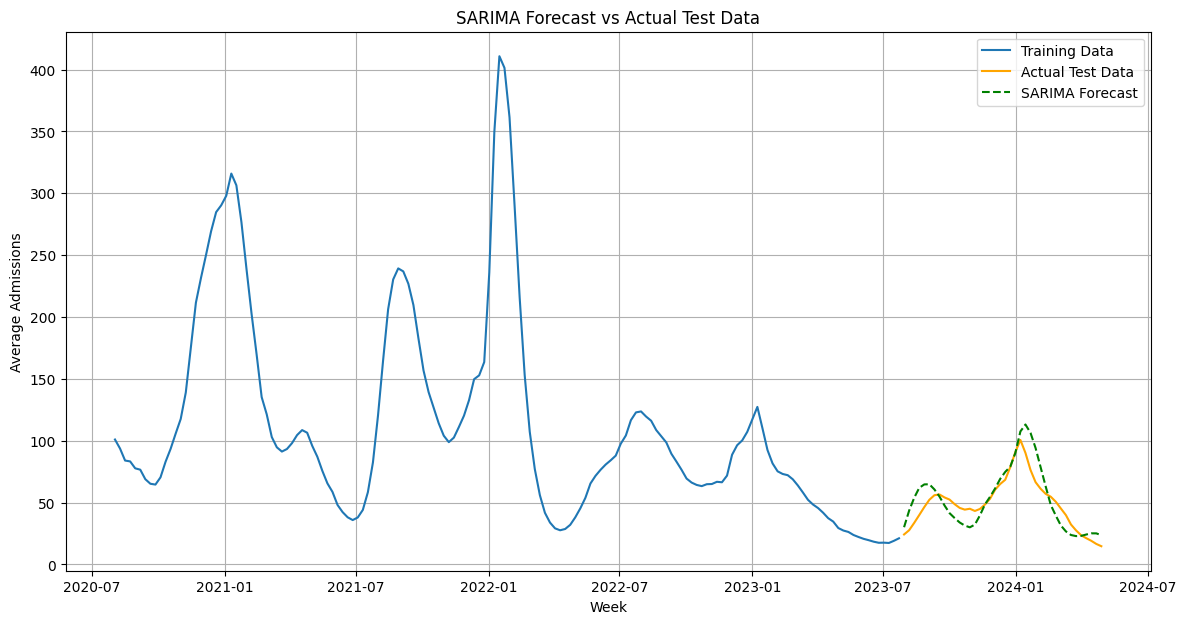

In [ ]:
# Get forecast for the length of the test data
forecast_test = sarima_results.get_forecast(steps=len(test_data))
forecast_mean_test = forecast_test.predicted_mean

# Plot the forecast vs actual validation data
plt.figure(figsize=(14, 7))
# Plot the target variable from the training data DataFrame
plt.plot(train_data.index, train_data['average_admissions_all_covid_confirmed'], label='Training Data')
# Plot the target variable from the test data DataFrame
plt.plot(test_data.index, test_data['average_admissions_all_covid_confirmed'], label='Actual Test Data', color='orange')
plt.plot(forecast_mean_test.index, forecast_mean_test, label='SARIMA Forecast', color='green', linestyle='--')
plt.title('SARIMA Forecast vs Actual Test Data')
plt.xlabel('Week')
plt.ylabel('Average Admissions')
plt.legend()
plt.grid(True)
plt.show()



Time Series Model Comparison:
              RMSE        MAE        MAPE        R2
Naive     5.773832   4.835779   10.192545  0.917056
Prophet  43.336107  35.722219   94.298214 -3.672598
VAR      47.494900  41.165218  120.980507 -4.612451
SARIMA   12.372174   9.885481   23.142213  0.619153


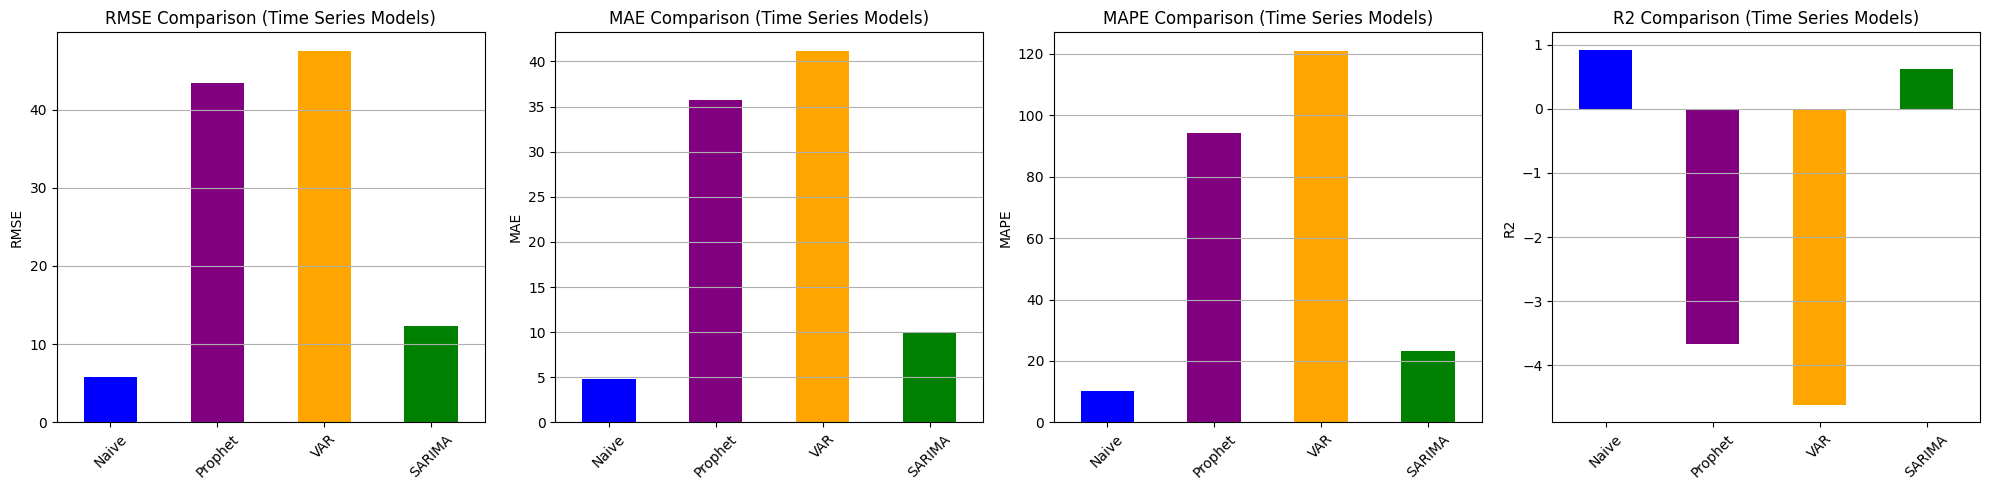


Time Series Model with the lowest RMSE: Naive (5.7738)
Time Series Model with the lowest MAPE: Naive (10.1925%)


In [ ]:
# Combine evaluation metrics for Time Series models
ts_results = {
    'Naive': {'RMSE': rmse_naive, 'MAE': mae_naive, 'MAPE': mape_naive, 'R2': r2_naive},
    'Prophet': {'RMSE': rmse_prophet, 'MAE': mae_prophet, 'MAPE': mape_prophet, 'R2': r2_prophet},
    'VAR': {'RMSE': rmse_var, 'MAE': mae_var, 'MAPE': mape_var, 'R2': r2_var},
    'SARIMA': {'RMSE': rmse_sarima, 'MAE': mae_sarima, 'MAPE': mape_sarima, 'R2': r2_sarima}
}

# Convert to DataFrame
ts_results_df = pd.DataFrame(ts_results).T
print("\nTime Series Model Comparison:")
print(ts_results_df)

# Visualize comparison of Time Series models
metrics_to_plot_ts = ['RMSE', 'MAE', 'MAPE', 'R2']
fig_ts, axes_ts = plt.subplots(1, len(metrics_to_plot_ts), figsize=(20, 5))

colors_ts = ['blue', 'purple', 'orange', 'green'] # Define distinct colors for TS models

for idx_ts, metric_ts in enumerate(metrics_to_plot_ts):
    ts_results_df[metric_ts].plot(kind='bar', ax=axes_ts[idx_ts], color=colors_ts)
    axes_ts[idx_ts].set_title(f'{metric_ts} Comparison (Time Series Models)')
    axes_ts[idx_ts].set_ylabel(metric_ts)
    axes_ts[idx_ts].set_xticklabels(ts_results_df.index, rotation=45)
    axes_ts[idx_ts].grid(axis='y')

plt.tight_layout()
plt.show()

# Identify the best Time Series model based on chosen metrics
best_ts_model_rmse = ts_results_df['RMSE'].idxmin()
print(f"\nTime Series Model with the lowest RMSE: {best_ts_model_rmse} ({ts_results_df.loc[best_ts_model_rmse, 'RMSE']:.4f})")

best_ts_model_mape = ts_results_df['MAPE'].idxmin()
print(f"Time Series Model with the lowest MAPE: {best_ts_model_mape} ({ts_results_df.loc[best_ts_model_mape, 'MAPE']:.4f}%)")

Despite its limitations in capturing sudden spikes (visible in the plot), SARIMA performs better than other seasonal models like Prophet, VAR, and Naive across key metrics:

* Lower MAE (9.89) than Prophet, VAR, and Naive, meaning it makes smaller average errors in predicting hospital admissions.

* Lower MAPE (23.14%), indicating more accurate percentage-based predictions.

* R² of 0.62 suggests SARIMA explains a reasonable portion of variance, better than Prophet and VAR.

* Among traditional seasonal time series models, SARIMA is the most reliable for forecasting hospital admissions. It balances seasonality detection with relatively lower errors (MAE and MAPE) compared to Prophet, VAR, and the Naive approach.


Comparison of Random Forest, LSTM, and SARIMA:
                      MSE       RMSE       MAE        R2       MAPE
Random Forest   27.593037   5.252908  4.014081  0.931347   0.096741
LSTM            42.030229   6.483073  4.353623  0.895427   9.363359
SARIMA         153.070689  12.372174  9.885481  0.619153  23.142213


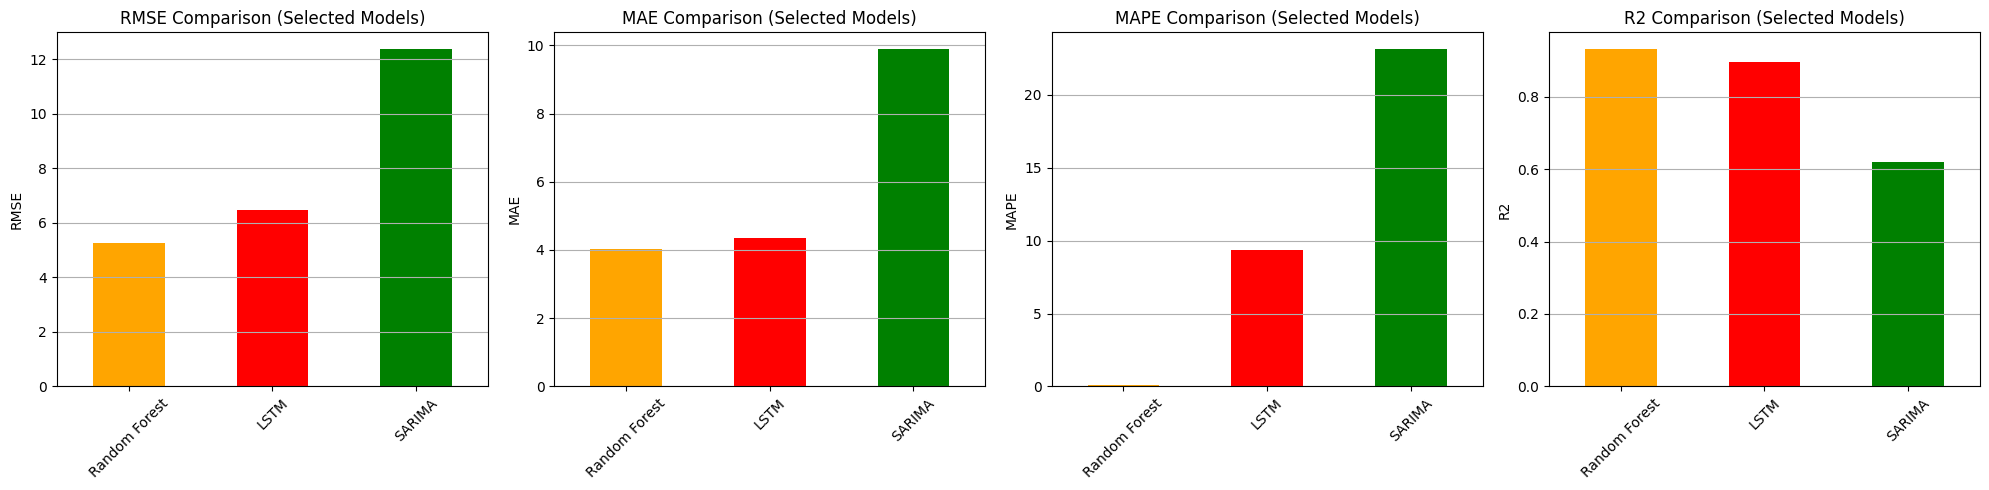


Selected Model with the lowest RMSE: Random Forest (5.2529)
Selected Model with the lowest MAPE: Random Forest (0.0967%)


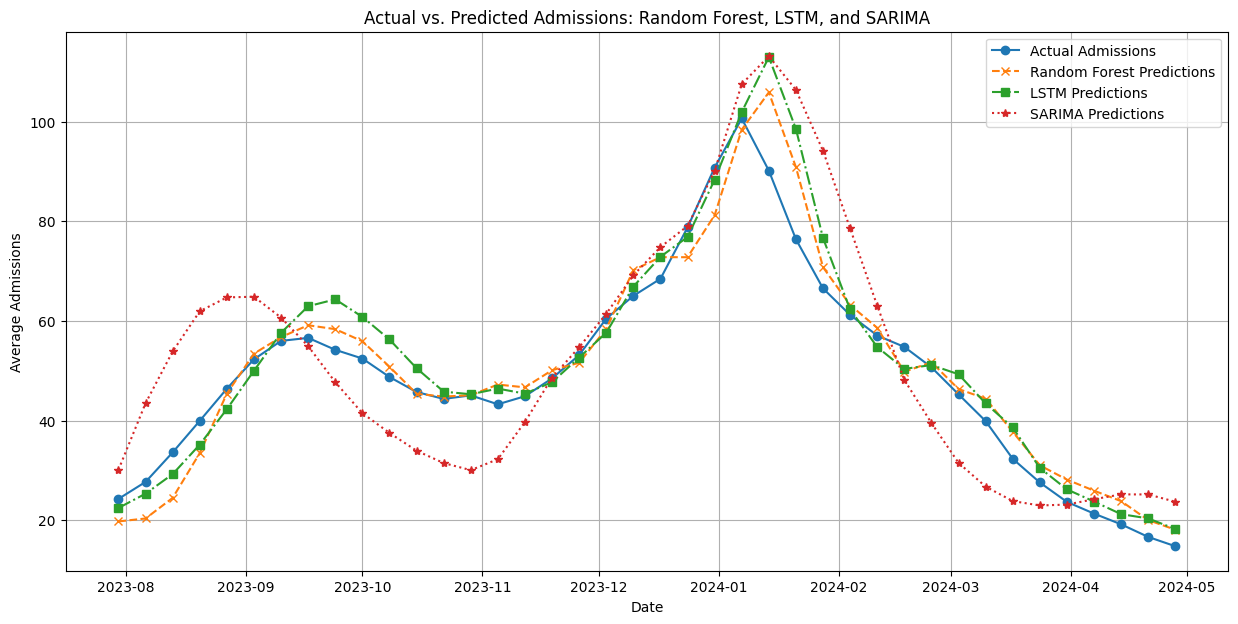

In [ ]:
# Comparing Random Forest, LSTM, and SARIMA models

# Store the evaluation metrics for the three requested models
selected_results = {
    'Random Forest': {'MSE': mse_rf, 'RMSE': rmse_rf, 'MAE': mae_rf, 'R2': r2_rf, 'MAPE': mape_rf},
    'LSTM': {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2_score(y_test, y_pred), 'MSE': mean_squared_error(y_test, y_pred)}, # Use metrics calculated for the LSTM model
    'SARIMA': {'RMSE': rmse_sarima, 'MAE': mae_sarima, 'MAPE': mape_sarima, 'R2': r2_sarima, 'MSE': mean_squared_error(y_test, sarima_pred)}
}

# Convert to DataFrame for easier comparison
selected_results_df = pd.DataFrame(selected_results).T
print("\nComparison of Random Forest, LSTM, and SARIMA:")
print(selected_results_df)

# Visualize comparison of the three models
metrics_to_plot_selected = ['RMSE', 'MAE', 'MAPE', 'R2']
fig_selected, axes_selected = plt.subplots(1, len(metrics_to_plot_selected), figsize=(20, 5))

colors_selected = ['orange', 'red', 'green'] # Define distinct colors

for idx_selected, metric_selected in enumerate(metrics_to_plot_selected):
    selected_results_df[metric_selected].plot(kind='bar', ax=axes_selected[idx_selected], color=colors_selected)
    axes_selected[idx_selected].set_title(f'{metric_selected} Comparison (Selected Models)')
    axes_selected[idx_selected].set_ylabel(metric_selected)
    axes_selected[idx_selected].set_xticklabels(selected_results_df.index, rotation=45)
    axes_selected[idx_selected].grid(axis='y')

plt.tight_layout()
plt.show()

# Identify the best model based on chosen metrics
best_selected_model_rmse = selected_results_df['RMSE'].idxmin()
print(f"\nSelected Model with the lowest RMSE: {best_selected_model_rmse} ({selected_results_df.loc[best_selected_model_rmse, 'RMSE']:.4f})")

best_selected_model_mape = selected_results_df['MAPE'].idxmin()
print(f"Selected Model with the lowest MAPE: {best_selected_model_mape} ({selected_results_df.loc[best_selected_model_mape, 'MAPE']:.4f}%)")

# Plot predictions vs actual for Random Forest, LSTM, and SARIMA on the test set
plt.figure(figsize=(15, 7))

# Plot Actual
plt.plot(y_test.index, y_test, label='Actual Admissions', marker='o', linestyle='-')

# Plot Random Forest Predictions
plt.plot(y_test.index, y_pred_rf, label='Random Forest Predictions', marker='x', linestyle='--')

# Plot LSTM Predictions
# Ensure y_pred (from LSTM) is aligned with y_test index
lstm_preds_series = pd.Series(y_pred, index=y_test.index)
plt.plot(lstm_preds_series.index, lstm_preds_series, label='LSTM Predictions', marker='s', linestyle='-.')

# Plot SARIMA Predictions
plt.plot(sarima_pred.index, sarima_pred, label='SARIMA Predictions', marker='*', linestyle=':')


plt.title('Actual vs. Predicted Admissions: Random Forest, LSTM, and SARIMA')
plt.xlabel('Date')
plt.ylabel('Average Admissions')
plt.legend()
plt.grid(True)
plt.show()

Among the time series models evaluate SARIMA stands out as the best model for capturing seasonal patterns and long-term trends in hospital admissions.

Here's why:

* RMSE (12.37): On average, the SARIMA model's predictions deviate from actual hospital admissions by about 12 patients, with larger errors weighted more heavily.

* Lowest MAE (9.89) among seasonal models — meaning SARIMA has the smallest average error in predicting weekly admissions.

* Lower MAPE (23.14%) than Prophet and VAR — indicating better percentage accuracy.

* R² of 0.62 — showing that SARIMA explains more variance in the data than the other time series models.

Visually (as seen in the plot), SARIMA follows seasonal trends more closely than Prophet or Naive, even though it slightly lags in sharp transitions.

Final Conclusion:

SARIMA is the most reliable time series model for this task. It balances trend and seasonality detection better than other classical models, making it the most appropriate choice for forecasting hospital admissions in a seasonally influenced dataset.

## CONCLUSIONS

1. Successfully integrated monitoring, modeling, and forecasting of COVID-19 hospitalizations.

2. Identified seasonal patterns and trends across U.S. states.

3. Produced short- and medium-term forecasts to support healthcare resource planning and policy decisions.

4. Developed real-time dashboards for timely communication with public health stakeholders.



## RECOMMENDATIONS

1. Strengthen Real-Time Data Infrastructure -Improve data collection systems to ensure timely, high-resolution reporting of hospitalization data across all counties in Kenya
2. Institutionalize Seasonal Surveillance and Early Warning Systems - Establish routine surveillance for respiratory viruses (including COVID-19, flu, RSV) with integrated modeling to detect seasonal surges.
3. Use historical data to develop baseline thresholds and early warning indicators for public health alerts.
4. Optimize Resource Allocation Based on Forecast Insights -  Develop tools that translate forecast outputs into actionable resource planning insights (e.g., ICU bed demand, staffing needs). Customize regional dashboards for hospital systems and local health departments to support decision-making.

5. Training for Local Public health agencies - Equip public health personnel with skills through targeted training and partnerships in long-term modeling capacity to ensure accurate forecasts to guide preparedness and response efforts.
